# Face Detection Notebook  
## Use Case: 美術館・ギャラリー向け「鑑賞スタイル分析」

本Notebookでは、展示作品を鑑賞している来場者の存在を  
顔検出によって把握し、以下を目的とする。

- 鑑賞者数の把握
- プライバシーに配慮した匿名化処理
- 鑑賞者の顔向き分析の前段階としての顔切り出し

今回は YOLO を用いて顔検出を行い、
1. ぼかしによる匿名化
2. 顔の画像置き換え (できなかった)
3. 切り出した顔のコラージュ作成
を行う。


(np.float64(-0.5), np.float64(980.5), np.float64(1668.5), np.float64(-0.5))

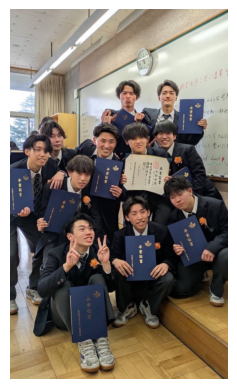

In [19]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("S__25518085.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis("off")



0: 640x384 5 persons, 1 tie, 1 laptop, 72.7ms
Speed: 5.7ms preprocess, 72.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


(np.float64(-0.5), np.float64(980.5), np.float64(1668.5), np.float64(-0.5))

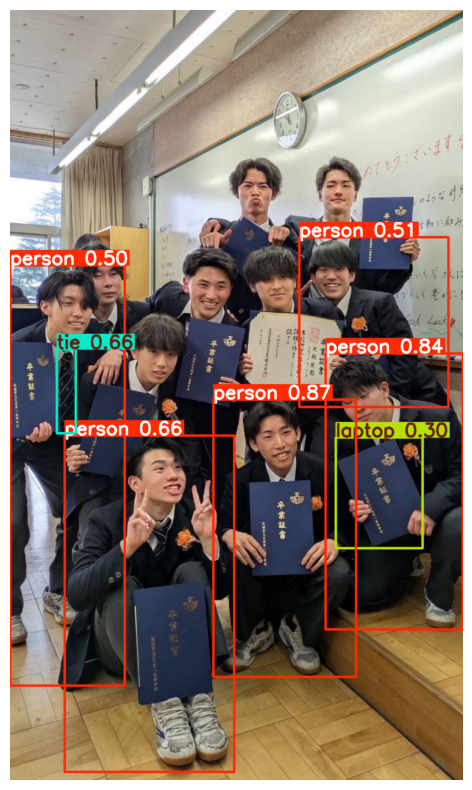

In [ ]:
from ultralytics import YOLO

# 通常のYOLOv8（自動ダウンロードされる）
model = YOLO("yolov8n.pt")

results = model(img_rgb)
annotated = results[0].plot()

import matplotlib.pyplot as plt
plt.imshow(annotated)
plt.axis("off")


In [ ]:
faces = results[0].boxes
print("検出された人数:", len(faces))


検出された人数: 7


### 検出結果の分析
- 画像内の鑑賞者数を把握できた
- 横顔や小さい顔は検出が難しい場合があった


In [ ]:
faces = []

for box in results[0].boxes:
    cls = int(box.cls[0])
    if results[0].names[cls] == "person":
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        h = y2 - y1

        # person領域の上30%を顔と仮定
        fx1 = x1
        fy1 = y1
        fx2 = x2
        fy2 = y1 + int(h * 0.3)

        faces.append((fx1, fy1, fx2, fy2))

print("顔領域数:", len(faces))


顔領域数: 5


(np.float64(-0.5), np.float64(980.5), np.float64(1668.5), np.float64(-0.5))

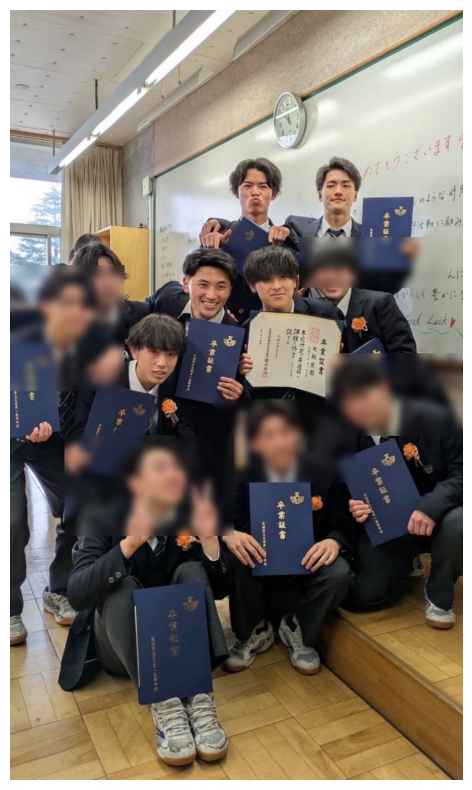

In [ ]:
blur_img = img_rgb.copy()

for (x1, y1, x2, y2) in faces:
    face = blur_img[y1:y2, x1:x2]
    face = cv2.GaussianBlur(face, (51, 51), 0)
    blur_img[y1:y2, x1:x2] = face

plt.imshow(blur_img)
plt.axis("off")


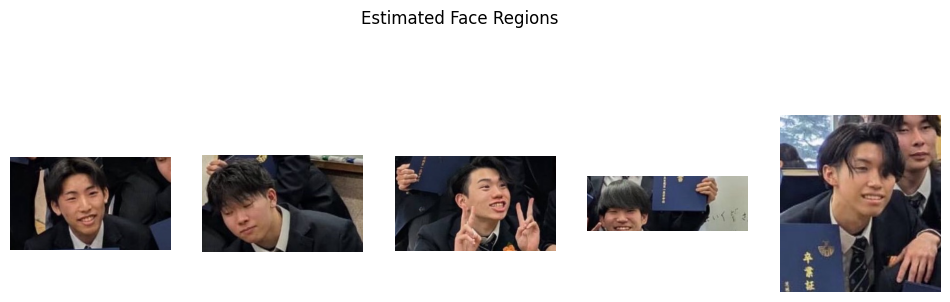

In [ ]:
face_images = []

for (x1, y1, x2, y2) in faces:
    face = img_rgb[y1:y2, x1:x2]
    face_images.append(face)

plt.figure(figsize=(12, 4))
for i, face in enumerate(face_images):
    plt.subplot(1, len(face_images), i + 1)
    plt.imshow(face)
    plt.axis("off")

plt.suptitle("Estimated Face Regions")
plt.show()


### 検出が難しかった点
YOLOv8は人物検出モデルであるため、
顔のみを直接検出することはできなかった。

そのため本Notebookでは、
人物検出結果の上部領域を
「顔が存在する可能性が高い部分」と仮定して分析を行った。

この方法は簡易的であり、
姿勢や構図によって誤差が生じる点が課題である。


## YOLO を使った所感

### 強み
- 高速に複数人の顔を検出できる
- 展示空間のような人の多い環境に向いている

### 弱み
- 横顔や小さな顔は見逃すことがある
- 暗い展示室では検出精度が低下する場合がある


## 今回のテーマでなぜ顔検出が必要か

鑑賞者の存在を検出することで、
- 作品ごとの注目度
- 滞在時間計測
- 視線分析の前処理
が可能になる。

顔検出は、美術館の展示改善や来場者体験向上に
有効な技術であると感じた。
